In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math 
import os 
from skimage.transform import resize
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report

### Import Data on Colab Platform

In [ ]:
import os
import json
from dotenv import load_dotenv

load_dotenv()


# --- UPDATE THESE TWO LINES ---
kaggle_username = "aurelienjacomy"
kaggle_key = os.getenv("KAGGLE_API_TOKEN_AJ")
# ------------------------------

# Define the data structure
api_token = {"username": kaggle_username, "key": kaggle_key}

# Create the directory
!mkdir -p ~/.kaggle

# Write the file directly
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

# Secure the file requirement
!chmod 600 ~/.kaggle/kaggle.json

# Test the connection
print("Testing Kaggle connection...")
!kaggle datasets list --sort-by hottest | head -n 5

In [ ]:
import kagglehub

# Download the dataset
print("Starting download with kagglehub...")
path = kagglehub.dataset_download("andyczhao/covidx-cxr2")

print("✅ Dataset downloaded to:", path)

# Check what's inside that path
import os
print("\nFiles in the dataset folder:")
print(os.listdir(path))

### DATA EXPLORATION

In [6]:
data_train = pd.read_csv('raw_data/train.txt', sep=' ', header=None)
data_train.columns = ['patient_id', 'filename', 'class', 'source']
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67863 entries, 0 to 67862
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  67863 non-null  object
 1   filename    67863 non-null  object
 2   class       67863 non-null  object
 3   source      67863 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


In [9]:
data_train.head()

,patient_id,filename,class,source
0,379,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative,cohen
1,379,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative,cohen
2,380,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative,cohen
3,380,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative,cohen
4,382,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative,cohen


In [10]:
data_train['class'].value_counts()

class
positive    57199
negative    10664
Name: count, dtype: int64

In [7]:
data_test = pd.read_csv('raw_data/test.txt', sep=' ', header=None)
data_test.columns = ['patient_id', 'filename', 'class', 'source']
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8482 entries, 0 to 8481
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  8482 non-null   object
 1   filename    8482 non-null   object
 2   class       8482 non-null   object
 3   source      8482 non-null   object
dtypes: object(4)
memory usage: 265.2+ KB


In [11]:
data_test.head()

,patient_id,filename,class,source
0,419639-003251,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive,ricord
1,419639-001464,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord
2,419639-000918,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord
3,419639-003318,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord
4,419639-001015,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord


In [12]:
data_test['class'].value_counts()

class
positive    4241
negative    4241
Name: count, dtype: int64

In [13]:
data_val = pd.read_csv('raw_data/val.txt', sep=' ', header=None)
data_val.columns = ['patient_id', 'filename', 'class', 'source']
data_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8473 entries, 0 to 8472
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  8473 non-null   object
 1   filename    8473 non-null   object
 2   class       8473 non-null   object
 3   source      8473 non-null   object
dtypes: object(4)
memory usage: 264.9+ KB


In [14]:
data_val['class'].value_counts()

class
positive    4241
negative    4232
Name: count, dtype: int64

In [15]:
# Create samples dataframe to test code faster

data_train_sample = data_train.sample(1000)
data_test_sample = data_test.sample(1000)
data_val_sample = data_val.sample(1000)

patient_id
S312524                                 1
ff3c2e94-b672-4bd2-8073-e9a4b6d9294d    1
ff42dbdc-285e-457d-aa3d-725638fa083b    1
ff47d677-c81f-4847-900b-a2cb12e06c3b    1
S29630                                  1
Name: count, dtype: int64

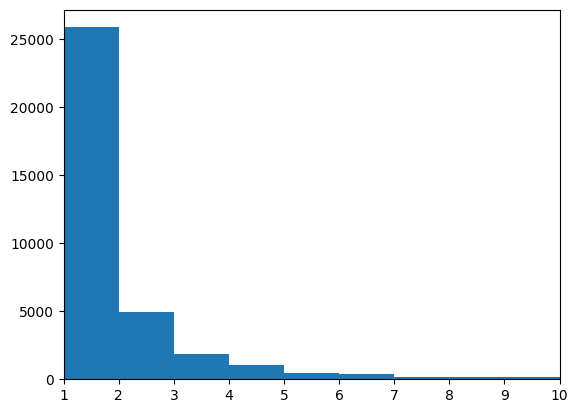

In [17]:
# How many picture by patient_id? 

patient_xray_counts = data_train["patient_id"].value_counts()
plt.hist(patient_xray_counts, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xlim(right=10, left=1)
patient_xray_counts.tail()


In [18]:
data_train[data_train["patient_id"]=='A860070']['class'].value_counts()

class
positive    236
Name: count, dtype: int64

Plot positive and negative cases

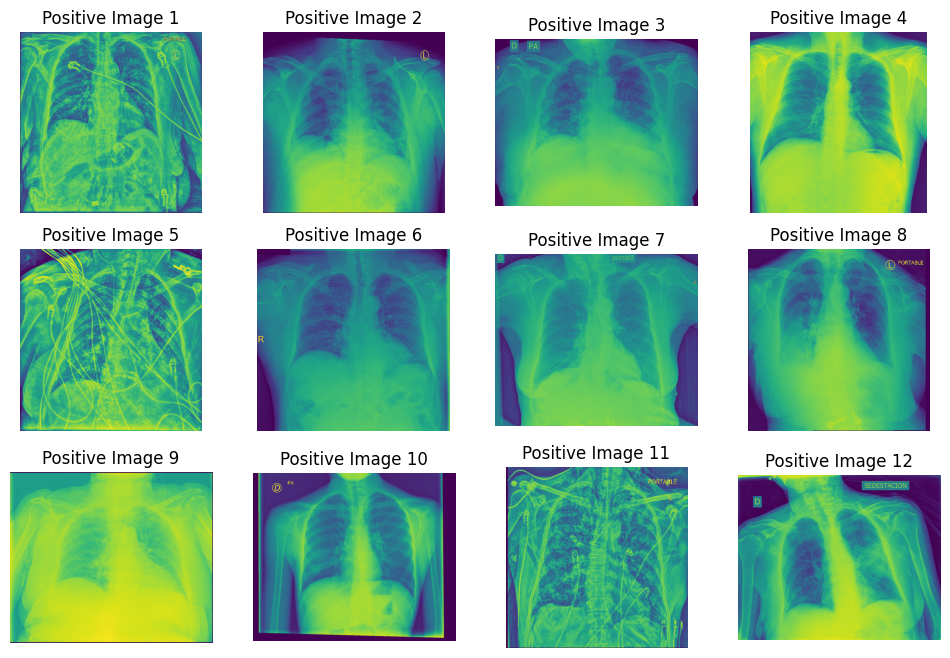

In [19]:
# Plot positive cases 

positive_cases = data_train[data_train['class']=='positive'].sample(12)

fig, axs = plt.subplots(3, 4, figsize=(12, 8))
axs = axs.flatten()

for i, filename in enumerate(positive_cases['filename']):
        filepath = f"raw_data/train/{filename}"
        img = mpimg.imread(filepath)
        axs[i].imshow(img)
        axs[i].axis('off')  # cacher les axes
        axs[i].set_title(f"Positive Image {i+1}")

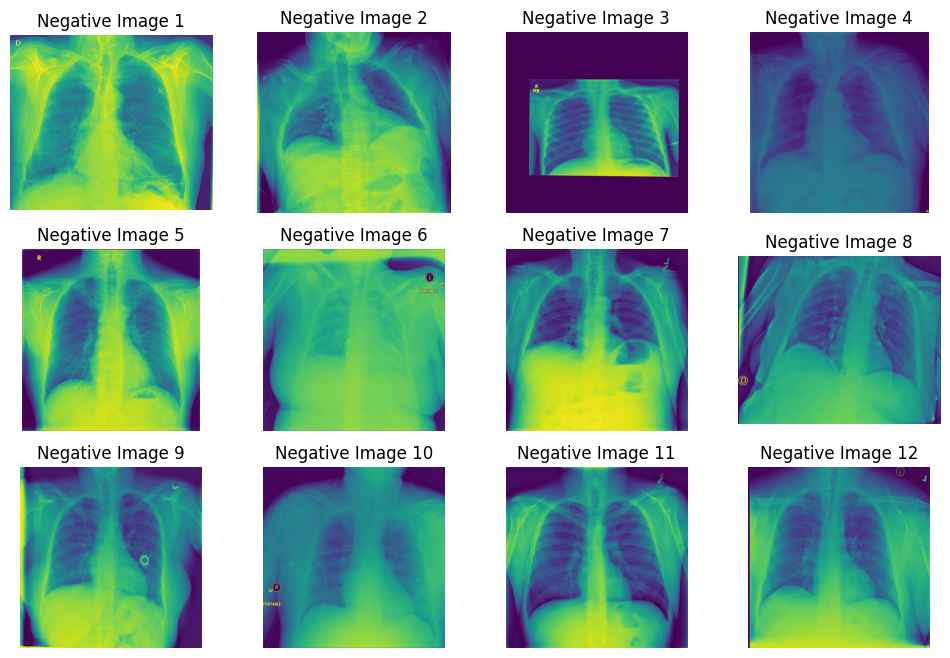

In [20]:
# Plot negative cases 

positive_cases = data_train[data_train['class']=='negative'].sample(12)

fig, axs = plt.subplots(3, 4, figsize=(12, 8))
axs = axs.flatten()

for i, filename in enumerate(positive_cases['filename']):
        filepath = f"raw_data/train/{filename}"
        img = mpimg.imread(filepath)
        axs[i].imshow(img)
        axs[i].axis('off')  # cacher les axes
        axs[i].set_title(f"Negative Image {i+1}")

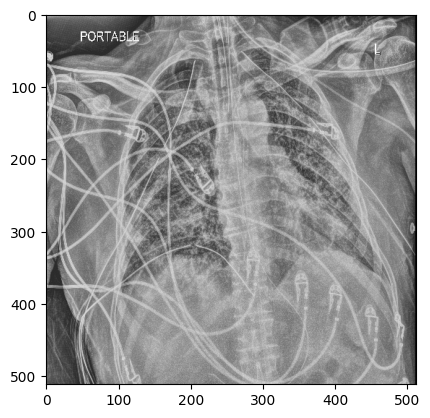

In [21]:
df = data_train
patient_id = 'A860070'
patient_data = df[df['patient_id'] == patient_id]
line = patient_data.iloc[0]
img_path = 'raw_data/train/'+line['filename']
img = mpimg.imread(img_path)
plt.imshow(img, cmap=plt.cm.gray)
plt.title = line['class']

In [22]:
# Let's have a look to image size and update df 

def image_size(row, set):
    filepath = f"raw_data/{set}/{row['filename']}"
    img = mpimg.imread(filepath)
    size_bytes = os.path.getsize(filepath)
    return img.shape[0], img.shape[1], img.ndim, size_bytes / 1024


In [23]:
data_train_sample[['height', 'width', 'channels', 'img_size_kb']] = data_train_sample.apply(
    lambda row: pd.Series(image_size(row, 'train')),
    axis=1
)

In [24]:
data_train_sample['channels'].value_counts()

channels
2.0    999
3.0      1
Name: count, dtype: int64

In [25]:
data_train_sample

,patient_id,filename,class,source,height,width,channels,img_size_kb
66279,S333133,sub-S333133_ses-E69082_run-1_bp-chest_vp-pa_dx...,positive,bimcv,843.0,1024.0,2.0,446.454102
2221,SITE2-000199,MIDRC-RICORD-1C-SITE2-000199-24703-0.png,positive,ricord,840.0,1024.0,2.0,476.653320
43216,S314536,sub-S314536_ses-E38749_run-1_bp-chest_vp-ap_dx...,positive,bimcv,886.0,1024.0,2.0,450.578125
23692,A222026,A222026-01-11-1901-NA-CHEST_AP_PORT-36169-2.00...,positive,stonybrook,512.0,512.0,2.0,134.509766
30625,S308304,sub-S308304_ses-E21287_run-1_bp-chest_vp-pa_dx...,positive,bimcv,1024.0,1024.0,2.0,511.125977
...,...,...,...,...,...,...,...,...
58957,S325853,sub-S325853_ses-E68579_run-1_bp-chest_vp-pa_dx...,positive,bimcv,852.0,1024.0,2.0,411.916016
52687,S320967,sub-S320967_ses-E46335_run-1_bp-chest_vp-pa_dx...,positive,bimcv,852.0,1024.0,2.0,383.368164
6281,23dde3cd-bdf6-4586-bf6d-8e3306c71455,23dde3cd-bdf6-4586-bf6d-8e3306c71455.png,negative,rsna,1024.0,1024.0,2.0,438.934570
38536,S311903,sub-S311903_ses-E56222_run-1_bp-chest_vp-pa_cr...,positive,bimcv,841.0,1024.0,2.0,352.142578


In [26]:
data_test_sample[['height', 'width', 'channels', 'img_size_kb']] = data_test_sample.apply(
    lambda row: pd.Series(image_size(row, 'test')),
    axis=1
)

data_test_sample['channels'].value_counts()

channels
2.0    1000
Name: count, dtype: int64

In [27]:
data_val_sample[['height', 'width', 'channels', 'img_size_kb']] = data_val_sample.apply(
    lambda row: pd.Series(image_size(row, 'val')),
    axis=1
)

data_val_sample['channels'].value_counts()

channels
2.0    986
3.0     14
Name: count, dtype: int64

There are only: 
- 0.4% of colour pictures in train set 
- 0.4% of colour pictures in val set
- None in the test set

We can exclude 3Dim pictures from our model.


(array([ 1.,  2.,  7.,  0.,  1.,  3., 14., 32., 35., 18.,  6.,  2.,  1.,
         1.,  0.,  4.,  5., 34., 29., 25.,  3.,  1.,  0.,  2.,  0.,  0.,
         0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  4.,  2.,  3.,  4.,
         7.,  5.,  4.,  7., 10.,  4.,  3.,  3., 10.,  9., 11., 21., 14.,
        32., 16., 28., 27., 23., 20., 23., 26., 26., 19., 13., 23., 31.,
        21., 32., 21., 22., 18., 16., 20., 22., 15., 14., 17., 10., 11.,
        10.,  8., 11., 15., 12.,  8.,  6.,  5.,  5.,  5.,  2.,  4.,  2.,
         1.,  2.,  0.,  4.,  2.,  0.,  0.,  0.,  1.]),
 array([ 17.2109375 ,  23.44257813,  29.67421875,  35.90585937,
         42.1375    ,  48.36914062,  54.60078125,  60.83242188,
         67.0640625 ,  73.29570312,  79.52734375,  85.75898437,
         91.990625  ,  98.22226562, 104.45390625, 110.68554688,
        116.9171875 , 123.14882812, 129.38046875, 135.61210937,
        141.84375   , 148.07539062, 154.30703125, 160.53867188,
        166.7703125 , 173.00195312, 179.23359375, 

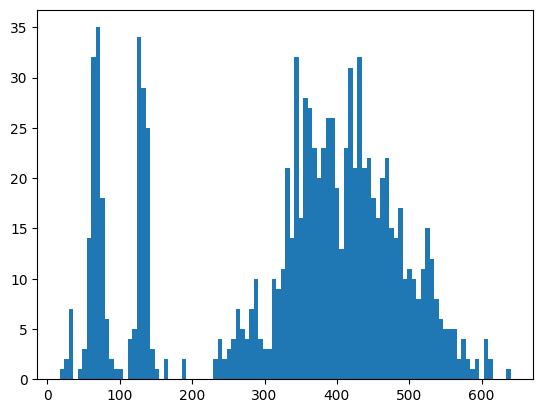

In [28]:
plt.hist(data_train_sample['img_size_kb'], bins=100)

(array([  7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
        183.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,
          7.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,
          1.,   1.,   3.,   1.,   2.,   3.,   2.,   2.,   4.,   5.,  10.,
        754.]),
 array([ 255.  ,  262.69,  270.38,  278.07,  285.76,  293.45,  301.14,
         308.83,  316.52,  324.21,  331.9 ,  339.59,  347.28,  354.97,
         362.66,  370.35,  378.04,  385.73,  393.42,  401.11,  408.8 ,
         416.49,  424.18,  431.87,  439.56,  447.25,  454.94,  462.63,
         470.32,  478.01,  485.7 ,

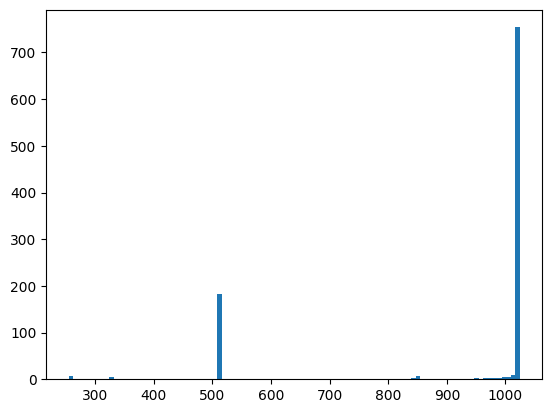

In [ ]:
plt.hist(data_train_sample['width'], bins=100)

(array([  7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
        183.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   1.,   3.,
          3.,   1.,   1.,   2.,   3.,   0.,   3.,   2.,  15.,   3., 256.,
        130.,  15.,   3.,   4.,   6.,   2.,   3.,   3.,   3.,   3.,   4.,
          3.,   2.,   5.,   5.,   3.,   5.,   5.,   1.,   7.,   5.,   4.,
        285.]),
 array([ 249.  ,  256.75,  264.5 ,  272.25,  280.  ,  287.75,  295.5 ,
         303.25,  311.  ,  318.75,  326.5 ,  334.25,  342.  ,  349.75,
         357.5 ,  365.25,  373.  ,  380.75,  388.5 ,  396.25,  404.  ,
         411.75,  419.5 ,  427.25,  435.  ,  442.75,  450.5 ,  458.25,
         466.  ,  473.75,  481.5 ,

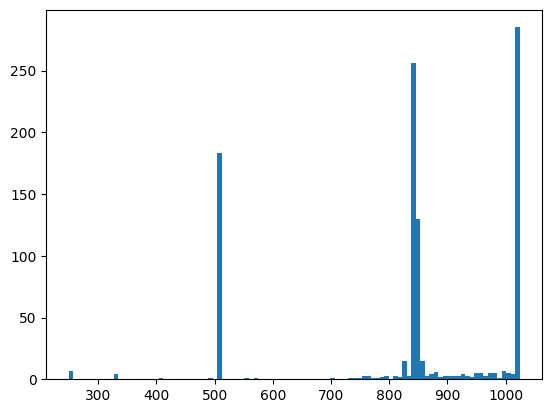

In [ ]:
plt.hist(data_train_sample['height'], bins=100)

In [29]:
def image_ratio(width, height):
    ratios = {
        "1:1": 1/1,
        "4:3": 4/3,
        "3:2": 3/2,
        "16:9": 16/9,
        "21:9": 21/9,
        "5:4": 5/4
    }

    actual_ratio = width / height

    closest = min(ratios.items(), key=lambda x: abs(actual_ratio - x[1]))

    return closest[0]

In [30]:
data_train_sample['image_ratio'] = data_train_sample.apply(lambda row: image_ratio(row['width'], row['height']), axis=1)
data_train_sample.head()

,patient_id,filename,class,source,height,width,channels,img_size_kb,image_ratio
66279,S333133,sub-S333133_ses-E69082_run-1_bp-chest_vp-pa_dx...,positive,bimcv,843.0,1024.0,2.0,446.454102,5:4
2221,SITE2-000199,MIDRC-RICORD-1C-SITE2-000199-24703-0.png,positive,ricord,840.0,1024.0,2.0,476.653320,5:4
43216,S314536,sub-S314536_ses-E38749_run-1_bp-chest_vp-ap_dx...,positive,bimcv,886.0,1024.0,2.0,450.578125,5:4
23692,A222026,A222026-01-11-1901-NA-CHEST_AP_PORT-36169-2.00...,positive,stonybrook,512.0,512.0,2.0,134.509766,1:1
30625,S308304,sub-S308304_ses-E21287_run-1_bp-chest_vp-pa_dx...,positive,bimcv,1024.0,1024.0,2.0,511.125977,1:1


In [31]:
data_train_sample['image_ratio'].value_counts()

image_ratio
1:1     518
5:4     470
4:3       8
3:2       3
16:9      1
Name: count, dtype: int64

In [32]:
from skimage import io, color, measure, filters
from skimage.measure import shannon_entropy
import numpy as np

def full_metrics(row, dataset):
    filepath = f"raw_data/{dataset}/{row['filename']}"
    img = io.imread(filepath)

    if img.ndim == 3:
        img = color.rgb2gray(img)

    brightness = np.mean(img)
    contrast = np.std(img)
    entropy = shannon_entropy(img)
    lap = filters.laplace(img)
    sharpness = lap.var()
    

    return brightness, contrast, entropy, sharpness

In [33]:
data_train_sample[['brightness', 'contrast', 'entropy', 'sharpness']] = data_train_sample.apply(lambda row: pd.Series(full_metrics(row, 'train')), axis=1)
#full_metrics(data_train_sample.iloc[0], 'train')

In [34]:
data_train_sample.head()

,patient_id,filename,class,source,height,width,channels,img_size_kb,image_ratio,brightness,contrast,entropy,sharpness
66279,S333133,sub-S333133_ses-E69082_run-1_bp-chest_vp-pa_dx...,positive,bimcv,843.0,1024.0,2.0,446.454102,5:4,125.179871,75.289627,7.114169,0.005613
2221,SITE2-000199,MIDRC-RICORD-1C-SITE2-000199-24703-0.png,positive,ricord,840.0,1024.0,2.0,476.653320,5:4,133.222240,51.505310,7.358509,0.004466
43216,S314536,sub-S314536_ses-E38749_run-1_bp-chest_vp-ap_dx...,positive,bimcv,886.0,1024.0,2.0,450.578125,5:4,168.986379,47.618174,7.221582,0.001723
23692,A222026,A222026-01-11-1901-NA-CHEST_AP_PORT-36169-2.00...,positive,stonybrook,512.0,512.0,2.0,134.509766,1:1,140.790791,35.752244,7.076090,0.032974
30625,S308304,sub-S308304_ses-E21287_run-1_bp-chest_vp-pa_dx...,positive,bimcv,1024.0,1024.0,2.0,511.125977,1:1,132.938624,76.499912,7.190321,0.005390


Text(0.5, 1.0, 'Sharpness')

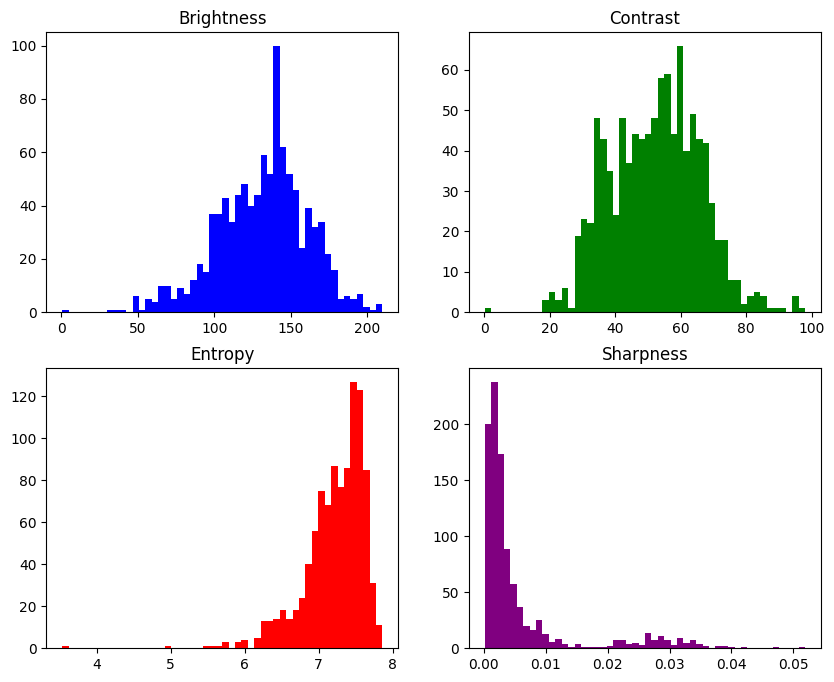

In [35]:
bins=50
fig, axs = plt.subplots(2, 2, figsize=(10,8)) 

axs[0,0].hist(data_train_sample['brightness'], color='blue', bins=bins)
axs[0,0].set_title("Brightness")

axs[0,1].hist(data_train_sample['contrast'], color='green', bins=bins)
axs[0,1].set_title("Contrast")

axs[1,0].hist(data_train_sample['entropy'], color='red', bins=bins)
axs[1,0].set_title("Entropy")

axs[1,1].hist(data_train_sample['sharpness'], color='purple', bins=bins)
axs[1,1].set_title("Sharpness")


### Baseline Model - PCA - Model Exploration

In [36]:
data_train_sample.shape, data_val_sample.shape, data_test_sample.shape

((1000, 13), (1000, 8), (1000, 8))

In [ ]:
# Build target
y_train_sample = data_train_sample['class']
y_train_sample = y_train_sample.map({"negative": 0, "positive": 1})
y_train_sample

66279    1
2221     1
43216    1
23692    1
30625    1
        ..
58957    1
52687    1
6281     0
38536    1
53906    1
Name: class, Length: 1000, dtype: int64

In [47]:
def flatten_and_resize_image(filename, dataset):
    # Flatten and resize an image to 256 x 256 pixels, grayscale 
    
    filepath = f"raw_data/{dataset}/{filename}"
    img = mpimg.imread(filepath)
    
    # Convert to grayscale if rgb image    
    if img.ndim ==3:
        img = color.rgb2gray(img[:, :, :3])
    
    # Resize to 256 x 256
    img_resized = resize(img, (64, 64), anti_aliasing=True)
   
    return img_resized.flatten()

In [48]:
# Build X_train with flattened images of 256 x 256

X_train_sample = data_train_sample.apply(lambda row: flatten_and_resize_image(row['filename'], 'train'), axis=1)
X_train_sample = pd.DataFrame(X_train_sample.tolist())


In [291]:
X_train_sample.head()


,0,1,2,3,4,5,6,7,8,9,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,0.054629,0.049615,0.081263,0.063535,0.078020,0.090117,0.059529,0.048357,0.075303,0.089558,...,9.219304e-02,0.072414,0.055617,0.097669,0.089776,0.094022,0.075913,0.072053,0.081160,0.086807
1,0.269808,0.272764,0.293018,0.383394,0.546373,0.557777,0.551353,0.575071,0.555359,0.498616,...,6.247828e-02,0.061605,0.063505,0.161378,0.098365,0.063035,0.102751,0.210998,0.176176,0.237415
2,0.020996,0.018505,0.018634,0.018076,0.018043,0.018837,0.018787,0.018493,0.018466,0.018889,...,5.055551e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.715720e-01,0.216707,0.172830,0.154932,0.115734,0.047441,0.004632,0.000009,0.000000,0.000000
4,0.003102,0.006163,0.004297,0.003858,0.003789,0.002708,0.002908,0.002527,0.002093,0.001898,...,4.936220e-01,0.611210,0.593961,0.485836,0.518788,0.501992,0.568228,0.598962,0.481075,0.290207


In [49]:
# Build PCA Model and check PCA Components

pca = PCA(n_components=250).fit(X_train_sample)
data_projected = pca.transform(X_train_sample)

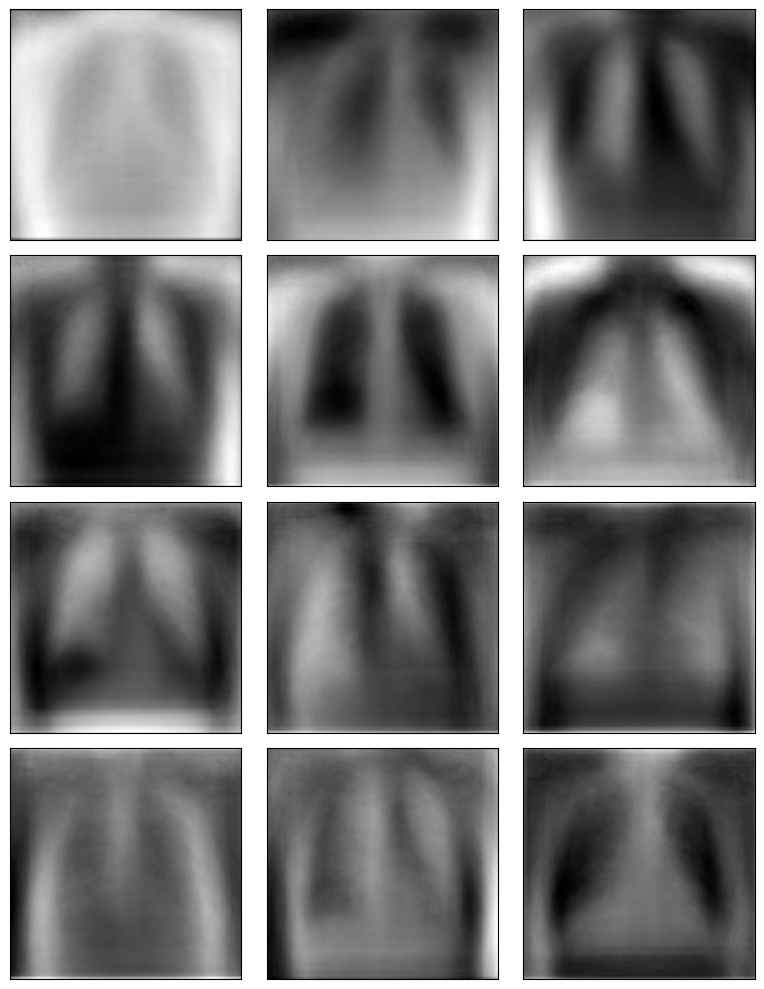

In [249]:
plt.figure(figsize=(8, 10))  # good size for 4x3 layout

for i in range(12):
    img = pca.components_[i].reshape(256, 256)
    
    plt.subplot(4, 3, i + 1)   # 4 rows, 3 columns
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

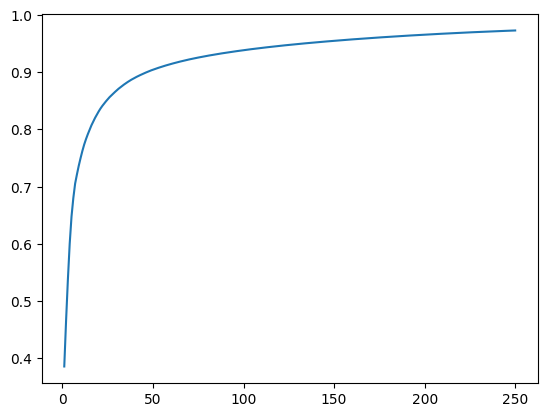

In [251]:
plt.plot(range(1, 251), np.cumsum(pca.explained_variance_ratio_))

In [50]:
# Choose optimized number of PCA Components - Step 1

pipeline = make_pipeline(PCA(), SVC())

In [ ]:
grid = {'pca__n_components': [50, 100, 200, 300]}
search = GridSearchCV(pipeline, param_grid=grid, cv=5)

search.fit(X_train_sample, y_train_sample)
best_model = search.best_estimator_
best_model

In [51]:
# Choose optimized number of PCA Components - Step 1

grid = {'pca__n_components': [1, 10, 30, 40, 50, 60, 70, 80]}
search = GridSearchCV(pipeline, param_grid=grid, cv=5)

search.fit(X_train_sample, y_train_sample)
best_model = search.best_estimator_
best_model

,steps,"[('pca', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_components,50
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10


In [52]:
# Evaluating model performance on sample
# Construct test dataset and target 
y_test_sample = data_test_sample['class'].map({"negative": 0, "positive": 1})
X_test_sample = data_test_sample.apply(lambda row: flatten_and_resize_image(row['filename'], 'test'), axis=1)
X_test_sample = pd.DataFrame(X_test_sample.tolist())

In [53]:
y_pred = best_model.predict(X_test_sample)
print(classification_report(y_test_sample, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.01      0.01       498
           1       0.50      1.00      0.67       502

    accuracy                           0.51      1000
   macro avg       0.75      0.50      0.34      1000
weighted avg       0.75      0.51      0.34      1000



In [301]:
# Radical Baseline
positive_test_share = y_train_sample.sum() / y_train_sample.size
positive_test_share

np.float64(0.843)

In [302]:
y_pred_basic = np.random.choice([0, 1], size=1000, p=[1 - positive_test_share, positive_test_share])
print(classification_report(y_test_sample, y_pred_basic))

              precision    recall  f1-score   support

           0       0.51      0.16      0.24       493
           1       0.51      0.86      0.64       507

    accuracy                           0.51      1000
   macro avg       0.51      0.51      0.44      1000
weighted avg       0.51      0.51      0.44      1000



### Baseline PCA - Full Model

In [3]:
data_train.shape, data_test.shape

NameError: name 'data_train' is not defined

In [ ]:
y_train = data_train['class'].map({"negative": 0, "positive": 1})
y_test = data_test['class'].map({"negative": 0, "positive": 1})

In [ ]:
X_train = data_train.apply(lambda row: flatten_and_resize_image(row['filename'], 'train'), axis=1)
X_train = pd.DataFrame(X_train.tolist())

X_test = data_test.apply(lambda row: flatten_and_resize_image(row['filename'], 'test'), axis=1)
X_test = pd.DataFrame(X_test.tolist())

: 

### Balanced Data

In [2]:
class Config:
    SEED = 42  # Ensuring that everyone get the exact same split!
    IMAGE_SIZE = (256, 256)
    
    # Kaggle Paths
    BASE_PATH = 'raw_data/'
    
    # Text Files
    TRAIN_TXT = os.path.join(BASE_PATH, 'train.txt')
    VAL_TXT   = os.path.join(BASE_PATH, 'val.txt')
    TEST_TXT  = os.path.join(BASE_PATH, 'test.txt')
    
    # Image Folders
    TRAIN_DIR = os.path.join(BASE_PATH, 'train')
    VAL_DIR   = os.path.join(BASE_PATH, 'val')
    TEST_DIR  = os.path.join(BASE_PATH, 'test')

# Set Seed for Reproducibility
np.random.seed(Config.SEED)
print("Configuration set. Seed fixed to:", Config.SEED)

Configuration set. Seed fixed to: 42


In [16]:
def flatten_and_resize_image(filepath):
    img = mpimg.imread(filepath)
    
    # Convert to grayscale if rgb image    
    if img.ndim ==3:
        img = rgb2gray(img[:, :, :3])
    
    # Resize to Image_Size
    img_resized = resize(img, Config.IMAGE_SIZE, anti_aliasing=True)
   
    return img_resized.flatten()

In [3]:
def read_data(txt_path, image_folder):
    """Reads a text file and adds the full path to the image folder."""
    # Read the file (Space separated)
    df = pd.read_csv(txt_path, sep=' ', header=None)
    df.columns = ['patient_id', 'filename', 'label', 'source']
    
    # Create the full path column so the generator can find the image later
    df['path'] = df['filename'].apply(lambda x: os.path.join(image_folder, x))
    return df

# --- 2. LOAD EVERYTHING ---
print("Loading original datasets...")
df_train = read_data(Config.TRAIN_TXT, Config.TRAIN_DIR)
df_val   = read_data(Config.VAL_TXT,   Config.VAL_DIR)
df_test  = read_data(Config.TEST_TXT,  Config.TEST_DIR)

# Combine them all into one big list
full_df = pd.concat([df_train, df_val, df_test], axis=0).reset_index(drop=True)
print(f"Total images found: {len(full_df)}")

Loading original datasets...
Total images found: 84818


In [5]:
# --- 3. BALANCE THE DATA ---
# We balance the data BEFORE splitting to keep things fair
min_count = full_df['label'].value_counts().min()
print(f"Balancing dataset to {min_count} images per class...")

# Take a random sample of 'min_count' from each class
balanced_df = full_df.groupby('label').apply(
    lambda x: x.sample(min_count, random_state=Config.SEED)
).reset_index(drop=True)

# Shuffle the final dataframe nicely
balanced_df = balanced_df.sample(frac=1, random_state=Config.SEED).reset_index(drop=True)

# --- 4. CREATE NEW SPLITS ---
# Split 1: 80% for Training, 20% for Temp (Val + Test)
b_train_df, b_test_df = train_test_split(
    balanced_df, 
    train_size=0.8, 
    stratify=balanced_df['label'], # Ensures 50/50 split in train
    random_state=Config.SEED
)

print(f"New Train Size: {len(b_train_df)}")
print(f"New Test Size:  {len(b_test_df)}")

Balancing dataset to 19137 images per class...
New Train Size: 30619
New Test Size:  7655


/var/folders/56/gjwm7vkj1yb71yj72fysz5h80000gn/T/ipykernel_70694/2554463194.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = full_df.groupby('label').apply(


In [8]:
b_train_df.head()

,patient_id,filename,label,source,path
4109,419639-000331,MIDRC-RICORD-1C-419639-000331-65699-0.png,positive,ricord,raw_data/val/MIDRC-RICORD-1C-419639-000331-656...
36141,S06213,sub-S06213_ses-E11922_run-1_bp-chest_vp-pa_cr-...,negative,bimcv,raw_data/test/sub-S06213_ses-E11922_run-1_bp-c...
25520,0a41d5c4-83b0-43e4-b98f-be69dcdd4636,0a41d5c4-83b0-43e4-b98f-be69dcdd4636.png,negative,rsna,raw_data/val/0a41d5c4-83b0-43e4-b98f-be69dcdd4...
20709,S314033,sub-S314033_ses-E36368_run-1_bp-chest_vp-ap_dx...,positive,bimcv,raw_data/train/sub-S314033_ses-E36368_run-1_bp...
37535,339,000007-15.jpg,negative,cohen,raw_data/val/000007-15.jpg


In [9]:
b_train_sample = b_train_df.sample(1000)
b_test_sample = b_test_df.sample(1000)


In [17]:
X_train_b = b_train_sample['path'].apply(lambda path: flatten_and_resize_image(path))
X_train_b = pd.DataFrame(X_train_b.tolist())
y_train_b = b_train_sample['label'].map({"negative": 0, "positive": 1})

In [19]:
pca_model = make_pipeline(PCA(n_components=30), SVC())
pca_model.fit(X_train_b, y_train_b)

,steps,"[('pca', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_components,30
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10


In [20]:
X_test_b = b_test_sample['path'].apply(lambda path: flatten_and_resize_image(path))
X_test_b = pd.DataFrame(X_test_b.tolist())
y_test_b = b_test_sample['label'].map({"negative": 0, "positive": 1})

In [21]:
y_pred_b = pca_model.predict(X_test_b)
print(classification_report(y_test_b, y_pred_b))

              precision    recall  f1-score   support

           0       0.74      0.69      0.71       521
           1       0.68      0.73      0.71       479

    accuracy                           0.71      1000
   macro avg       0.71      0.71      0.71      1000
weighted avg       0.71      0.71      0.71      1000

